## Maximum Likelihood Estimation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma
from scipy.optimize import minimize
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [2]:
plt.rcParams["figure.figsize"] = (10,4)

sns.set(font_scale=1)
sns.set_style("dark")

In [3]:
def run_plots(x, grid, vtrue, vmle=None, vkde=None):
    plt.hist(x, bins=50, density=True, 
             color='blue', edgecolor='black', alpha=0.5)
    plt.plot(grid, vtrue, label='True Density', c='black', lw=5, alpha=0.75)
    if vmle is not None:
        plt.plot(grid, vmle, label='MLE Density', c='green', lw=5, alpha=0.75)
    if vkde is not None:
        plt.plot(grid, vkde, label='KDE Density', c='red', lw=5, alpha=0.75)
    plt.legend()
    plt.savefig('likeli.png')
    plt.show()

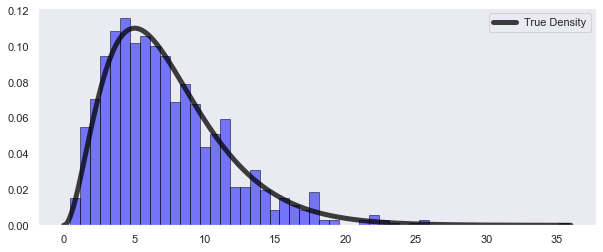

In [4]:
n = 1000

k_true = 3.1
t_true = 2.4

x = gamma.rvs(a=k_true, loc=0, scale=t_true, size=n, random_state=14)
g = np.linspace(np.floor(np.min(x)), np.ceil(np.max(x)), n)
ytrue = gamma.pdf(g, a=k_true, loc=0, scale=t_true)

run_plots(x=x, grid=g, vtrue=ytrue)

In [5]:
k_init = 1
t_init = 1
params = np.array([k_init, t_init])

def compute_log_likeli(params, vals):
    shape, scale = params[0], params[1]
    neg_ll = -np.sum(gamma.logpdf(vals, a=shape, loc=0, scale=scale))
    return(neg_ll)

# need to maximize log likelihood
# instead negative log likelihood is minimized
# which is the exactly the same
results = minimize(
    compute_log_likeli,
    params,
    args=(x),
    method='Nelder-Mead',
    options={'maxiter': 1000, 'disp': True}
)

Optimization terminated successfully.
         Current function value: 2745.153363
         Iterations: 51
         Function evaluations: 98


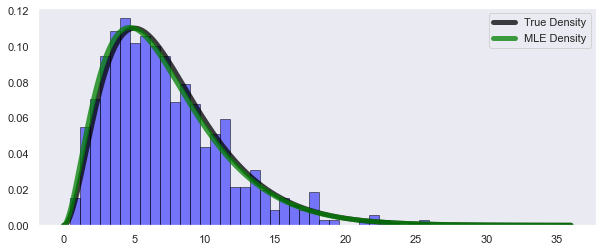

In [6]:
k_optim = results['x'][0]
t_optim = results['x'][1]
ymle = gamma.pdf(g, a=k_optim, loc=0, scale=t_optim)

run_plots(x=x, grid=g, vtrue=ytrue, vmle=ymle)

/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best Bandwidth: 1.438449888287663


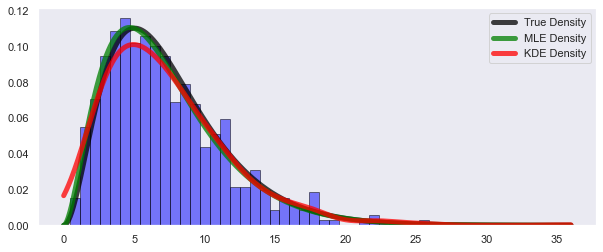

In [7]:
bws = {'bandwidth': np.logspace(-1, 1, 20)}

x_reshape = x.reshape(-1, 1)
g_reshape = g.reshape(-1, 1)

gscv = GridSearchCV(estimator=KernelDensity(), 
                    param_grid=bws, 
                    iid=False, cv=3, refit=True).fit(x_reshape)
bw_optim = gscv.best_estimator_.bandwidth
print('Best Bandwidth: {}'.format(bw_optim))

kde = KernelDensity(bandwidth=bw_optim).fit(x_reshape)
ykde = np.exp(kde.score_samples(g_reshape))

run_plots(x=x, grid=g, vtrue=ytrue, vmle=ymle, vkde=ykde)

In [8]:
# MLE curve is very similar to the true Gamma curve
# true shape 3.1 -> mle shape 3.003
# true scale 2.4 -> mle scale 2.593
# KDE is a decent estimate, but not nearly as good as MLE
# KDE is better in multiple dimensions, whereas MLE will 
#     struggle if the number of dimensions gets very large